In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,0.001620,0.173233,3b1ef8aa
1,reference-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,0.000927,0.174820,503ccebc
2,baseline,generic_1,False,False,True,True,False,bitcoin,6,21327,17.422045,0.344986,4bb29870
3,baseline,generic_1,False,False,True,True,False,ethereum_3,6,32961,24.555598,0.444027,36b8ff99
4,baseline,generic_1,False,False,True,True,False,byzantium_3,6,33016,25.587397,0.445107,747a996f
5,baseline,generic_1,False,False,True,True,False,ghostdag_3,6,46966,42.345118,0.543316,3ab8938a
6,baseline,generic_1,False,False,True,True,False,parallel_3,6,9122,5.548876,0.272751,1b1c3361
7,w/ force consider,generic_1,True,False,True,True,False,bitcoin,6,549,0.311148,0.224998,4c5b97de
8,w/ force consider,generic_1,True,False,True,True,False,ethereum_3,6,1179,0.761512,0.233868,601fa1bc
9,w/ force consider,generic_1,True,False,True,True,False,byzantium_3,6,1109,0.808308,0.237789,33fc451a


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("5-value-iterations.pkl.gz")
df

  0%|                                                                                                  | 0/88 [00:00<?, ?it/s]

  1%|█                                                                                         | 1/88 [00:00<00:16,  5.25it/s]

  2%|██                                                                                        | 2/88 [00:00<00:13,  6.16it/s]

  3%|███                                                                                     | 3/88 [02:28<1:36:11, 67.90s/it]

  5%|███▉                                                                                   | 4/88 [06:18<3:04:37, 131.87s/it]

  6%|████▉                                                                                  | 5/88 [09:12<3:23:10, 146.87s/it]

  7%|█████▉                                                                                 | 6/88 [12:52<3:54:37, 171.67s/it]

  8%|██████▉                                                                                | 7/88 [13:43<2:58:41, 132.36s/it]

  9%|████████                                                                                | 8/88 [13:46<2:01:31, 91.14s/it]

 10%|█████████                                                                               | 9/88 [13:51<1:24:38, 64.29s/it]

 11%|██████████                                                                               | 10/88 [13:56<59:32, 45.80s/it]

 12%|███████████▏                                                                             | 11/88 [14:01<43:01, 33.52s/it]

 14%|████████████▏                                                                            | 12/88 [14:10<32:55, 25.99s/it]

 15%|█████████████▏                                                                           | 13/88 [14:45<36:03, 28.85s/it]

 16%|██████████████▏                                                                          | 14/88 [15:48<48:16, 39.14s/it]

 17%|███████████████▏                                                                         | 15/88 [16:35<50:13, 41.27s/it]

 18%|████████████████▏                                                                        | 16/88 [17:29<54:23, 45.33s/it]

 19%|█████████████████▏                                                                       | 17/88 [17:38<40:39, 34.36s/it]

 20%|██████████████████▏                                                                      | 18/88 [17:40<28:35, 24.51s/it]

 22%|███████████████████▏                                                                     | 19/88 [17:42<20:39, 17.96s/it]

 23%|████████████████████▏                                                                    | 20/88 [17:45<15:03, 13.29s/it]

 24%|█████████████████████▏                                                                   | 21/88 [17:47<11:08,  9.97s/it]

 25%|██████████████████████▎                                                                  | 22/88 [17:49<08:27,  7.69s/it]

 26%|███████████████████████▎                                                                 | 23/88 [17:50<05:54,  5.45s/it]

 27%|████████████████████████▎                                                                | 24/88 [17:50<04:07,  3.86s/it]

 28%|█████████████████████████▎                                                               | 25/88 [20:19<49:54, 47.53s/it]

 30%|█████████████████████████▍                                                            | 26/88 [24:29<1:51:52, 108.26s/it]

 31%|██████████████████████████▍                                                           | 27/88 [27:57<2:20:23, 138.09s/it]

 32%|███████████████████████████▎                                                          | 28/88 [31:29<2:40:20, 160.35s/it]

 33%|████████████████████████████▎                                                         | 29/88 [32:15<2:03:51, 125.96s/it]

 34%|█████████████████████████████▋                                                         | 30/88 [32:18<1:26:03, 89.03s/it]

 35%|██████████████████████████████▋                                                        | 31/88 [32:23<1:00:40, 63.86s/it]

 36%|████████████████████████████████▎                                                        | 32/88 [32:28<43:01, 46.11s/it]

 38%|█████████████████████████████████▍                                                       | 33/88 [32:33<30:59, 33.81s/it]

 39%|██████████████████████████████████▍                                                      | 34/88 [32:41<23:33, 26.18s/it]

 40%|███████████████████████████████████▍                                                     | 35/88 [33:19<26:16, 29.74s/it]

 41%|████████████████████████████████████▍                                                    | 36/88 [34:24<34:55, 40.30s/it]

 42%|█████████████████████████████████████▍                                                   | 37/88 [35:15<37:00, 43.54s/it]

 43%|██████████████████████████████████████▍                                                  | 38/88 [36:10<39:13, 47.07s/it]

 44%|███████████████████████████████████████▍                                                 | 39/88 [36:20<29:12, 35.77s/it]

 45%|████████████████████████████████████████▍                                                | 40/88 [36:22<20:26, 25.56s/it]

 47%|█████████████████████████████████████████▍                                               | 41/88 [36:24<14:41, 18.76s/it]

 48%|██████████████████████████████████████████▍                                              | 42/88 [36:27<10:44, 14.01s/it]

 49%|███████████████████████████████████████████▍                                             | 43/88 [36:30<07:51, 10.49s/it]

 50%|████████████████████████████████████████████▌                                            | 44/88 [36:32<05:54,  8.06s/it]

 51%|█████████████████████████████████████████████▌                                           | 45/88 [36:32<04:05,  5.71s/it]

 52%|██████████████████████████████████████████████▌                                          | 46/88 [36:32<02:49,  4.04s/it]

 53%|███████████████████████████████████████████████▌                                         | 47/88 [39:00<32:14, 47.17s/it]

 55%|██████████████████████████████████████████████▉                                       | 48/88 [43:08<1:11:30, 107.25s/it]

 56%|███████████████████████████████████████████████▉                                      | 49/88 [46:33<1:28:49, 136.67s/it]

 57%|████████████████████████████████████████████████▊                                     | 50/88 [50:25<1:44:43, 165.35s/it]

 58%|█████████████████████████████████████████████████▊                                    | 51/88 [51:12<1:20:02, 129.81s/it]

 59%|████████████████████████████████████████████████████▌                                    | 52/88 [51:15<55:02, 91.73s/it]

 60%|█████████████████████████████████████████████████████▌                                   | 53/88 [51:20<38:24, 65.84s/it]

 61%|██████████████████████████████████████████████████████▌                                  | 54/88 [51:25<26:56, 47.56s/it]

 62%|███████████████████████████████████████████████████████▋                                 | 55/88 [51:31<19:11, 34.90s/it]

 64%|████████████████████████████████████████████████████████▋                                | 56/88 [51:39<14:23, 26.99s/it]

 65%|█████████████████████████████████████████████████████████▋                               | 57/88 [52:16<15:24, 29.81s/it]

 66%|██████████████████████████████████████████████████████████▋                              | 58/88 [53:29<21:22, 42.75s/it]

 67%|███████████████████████████████████████████████████████████▋                             | 59/88 [54:23<22:17, 46.13s/it]

 68%|████████████████████████████████████████████████████████████▋                            | 60/88 [55:22<23:24, 50.15s/it]

 69%|█████████████████████████████████████████████████████████████▋                           | 61/88 [55:31<17:03, 37.92s/it]

 70%|██████████████████████████████████████████████████████████████▋                          | 62/88 [55:33<11:44, 27.08s/it]

 72%|███████████████████████████████████████████████████████████████▋                         | 63/88 [55:36<08:15, 19.83s/it]

 73%|████████████████████████████████████████████████████████████████▋                        | 64/88 [55:39<05:52, 14.69s/it]

 74%|█████████████████████████████████████████████████████████████████▋                       | 65/88 [55:41<04:13, 11.01s/it]

 75%|██████████████████████████████████████████████████████████████████▊                      | 66/88 [55:44<03:06,  8.46s/it]

 76%|███████████████████████████████████████████████████████████████████▊                     | 67/88 [55:44<02:05,  5.99s/it]

 77%|████████████████████████████████████████████████████████████████████▊                    | 68/88 [55:44<01:24,  4.25s/it]

 78%|█████████████████████████████████████████████████████████████████████▊                   | 69/88 [58:26<16:16, 51.38s/it]

 80%|████████████████████████████████████████████████████████████████████▍                 | 70/88 [1:02:43<33:57, 113.21s/it]

 81%|█████████████████████████████████████████████████████████████████████▍                | 71/88 [1:06:38<42:27, 149.83s/it]

 82%|██████████████████████████████████████████████████████████████████████▎               | 72/88 [1:10:45<47:39, 178.74s/it]

 83%|███████████████████████████████████████████████████████████████████████▎              | 73/88 [1:11:31<34:43, 138.93s/it]

 84%|█████████████████████████████████████████████████████████████████████████▏             | 74/88 [1:11:34<22:54, 98.17s/it]

 85%|██████████████████████████████████████████████████████████████████████████▏            | 75/88 [1:11:39<15:14, 70.35s/it]

 86%|███████████████████████████████████████████████████████████████████████████▏           | 76/88 [1:11:44<10:08, 50.71s/it]

 88%|████████████████████████████████████████████████████████████████████████████▏          | 77/88 [1:11:49<06:47, 37.08s/it]

 89%|█████████████████████████████████████████████████████████████████████████████          | 78/88 [1:11:58<04:46, 28.65s/it]

 90%|██████████████████████████████████████████████████████████████████████████████         | 79/88 [1:12:38<04:48, 32.03s/it]

 91%|███████████████████████████████████████████████████████████████████████████████        | 80/88 [1:13:48<05:48, 43.50s/it]

 92%|████████████████████████████████████████████████████████████████████████████████       | 81/88 [1:14:50<05:41, 48.83s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████      | 82/88 [1:15:49<05:11, 51.95s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████     | 83/88 [1:15:58<03:16, 39.25s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████    | 84/88 [1:16:00<01:52, 28.02s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████   | 85/88 [1:16:03<01:01, 20.49s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████  | 86/88 [1:16:06<00:30, 15.17s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████ | 87/88 [1:16:08<00:11, 11.32s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 88/88 [1:16:11<00:00,  8.66s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 88/88 [1:16:11<00:00, 51.95s/it]

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,...,0.33,1,0.000994,0.001,716,0,0.188502,37.361978,98.457137,0.379475
1,reference-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,...,0.33,1,0.000996,0.001,1101,0,0.141063,36.972332,98.196826,0.376512
2,baseline,generic_1,False,False,True,True,False,bitcoin,6,21327,...,0.33,1,0.000999,0.001,1416,0,147.446834,36.645256,98.251549,0.372974
3,baseline,generic_1,False,False,True,True,False,ethereum_3,6,32961,...,0.33,1,0.000999,0.001,1740,0,228.577487,50.585667,98.353593,0.514325
4,baseline,generic_1,False,False,True,True,False,byzantium_3,6,33016,...,0.33,1,0.001000,0.001,1274,0,171.888952,35.591285,98.175497,0.362527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,w/ both,generic_1,True,True,True,True,False,bitcoin,6,300,...,0.66,1,0.000997,0.001,1619,0,1.802180,50.993481,98.639087,0.516970
84,w/ both,generic_1,True,True,True,True,False,ethereum_3,6,596,...,0.66,1,0.000995,0.001,1458,0,2.913976,52.981254,98.445556,0.538178
85,w/ both,generic_1,True,True,True,True,False,byzantium_3,6,572,...,0.66,1,0.000998,0.001,1395,0,2.732331,46.480770,98.483476,0.471965
86,w/ both,generic_1,True,True,True,True,False,ghostdag_3,6,604,...,0.66,1,0.000991,0.001,1086,0,2.318402,40.086100,98.145192,0.408437


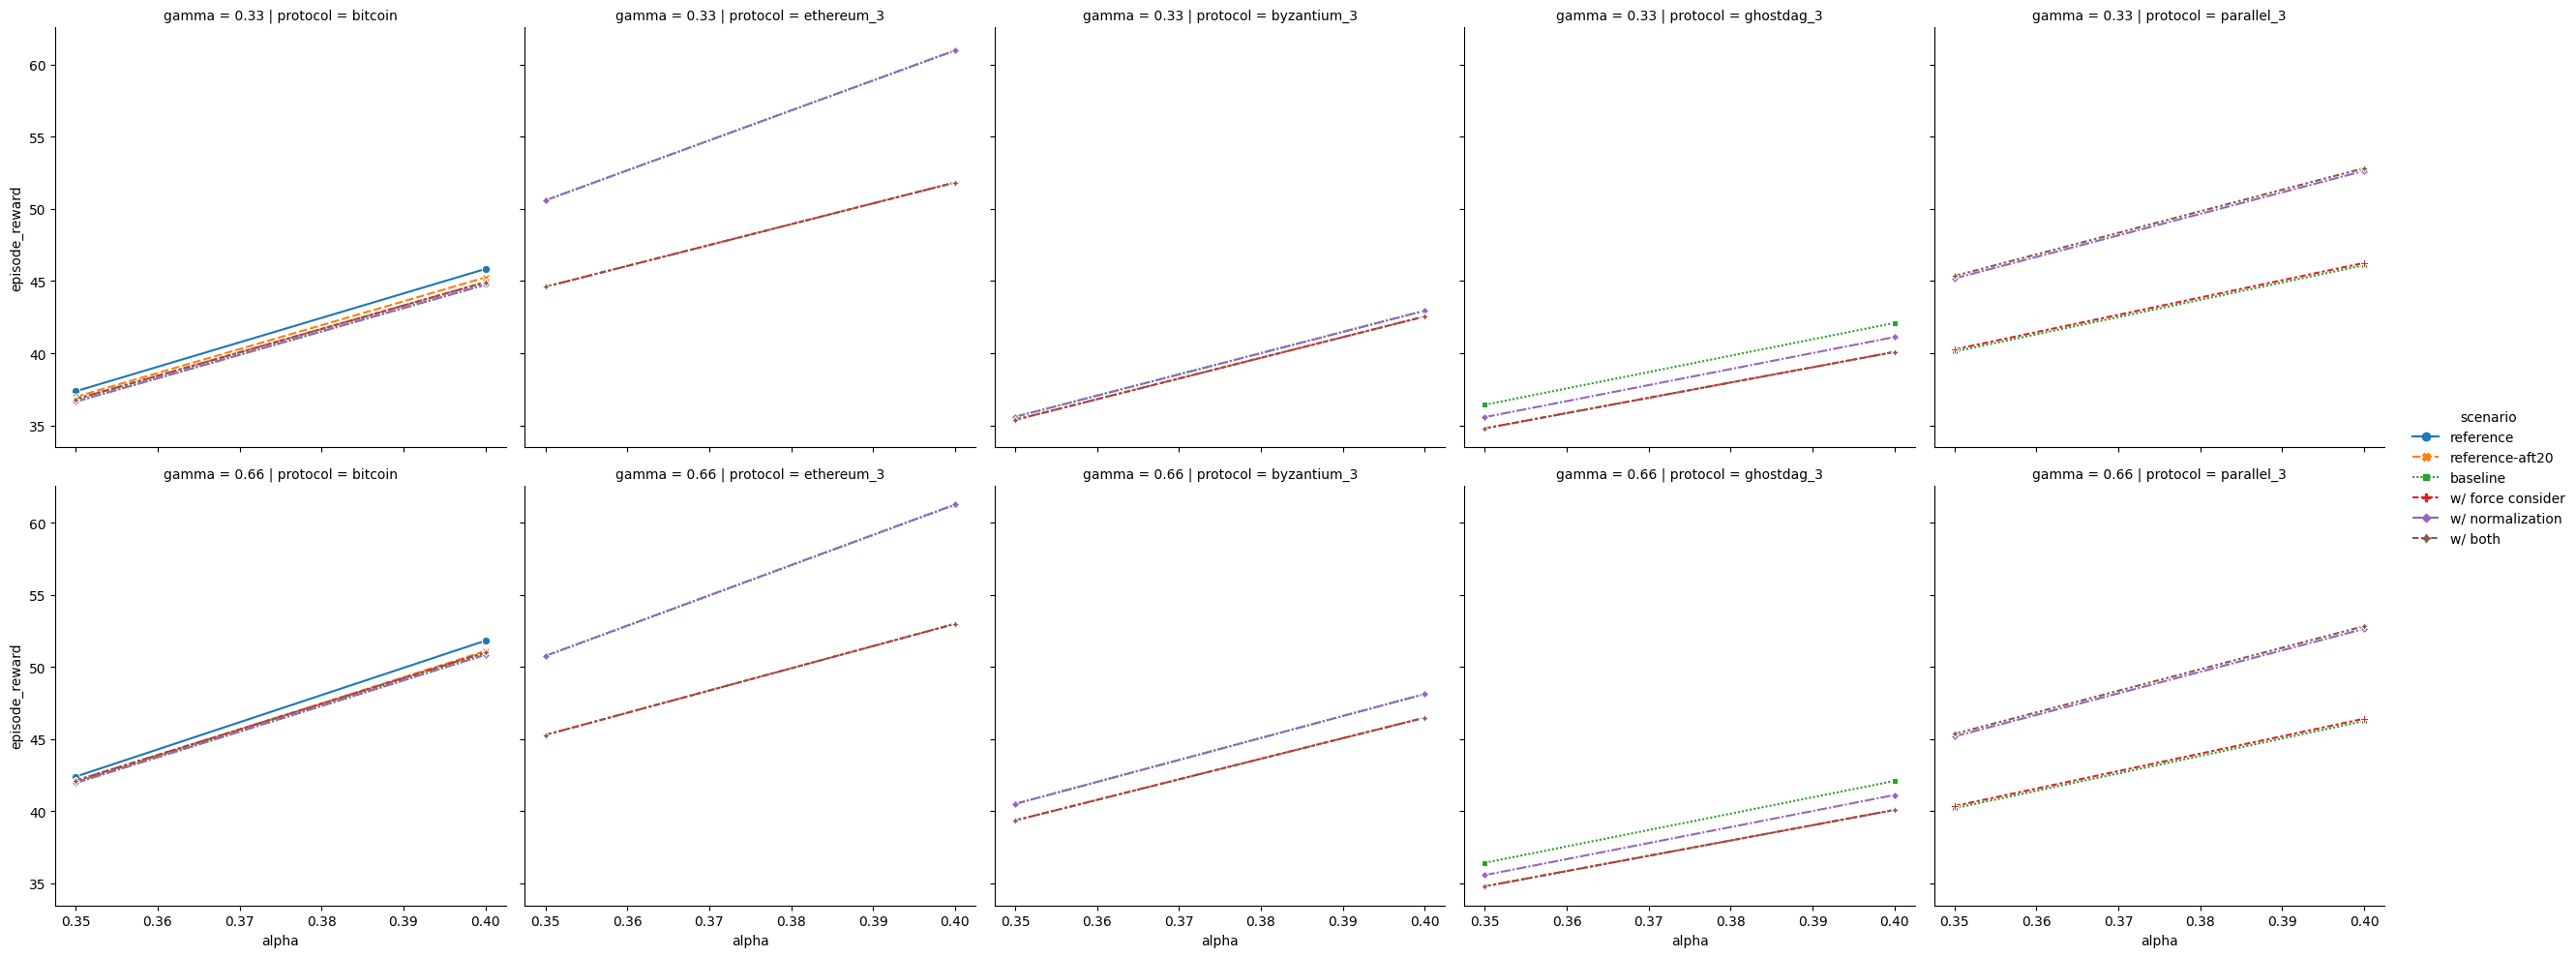

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

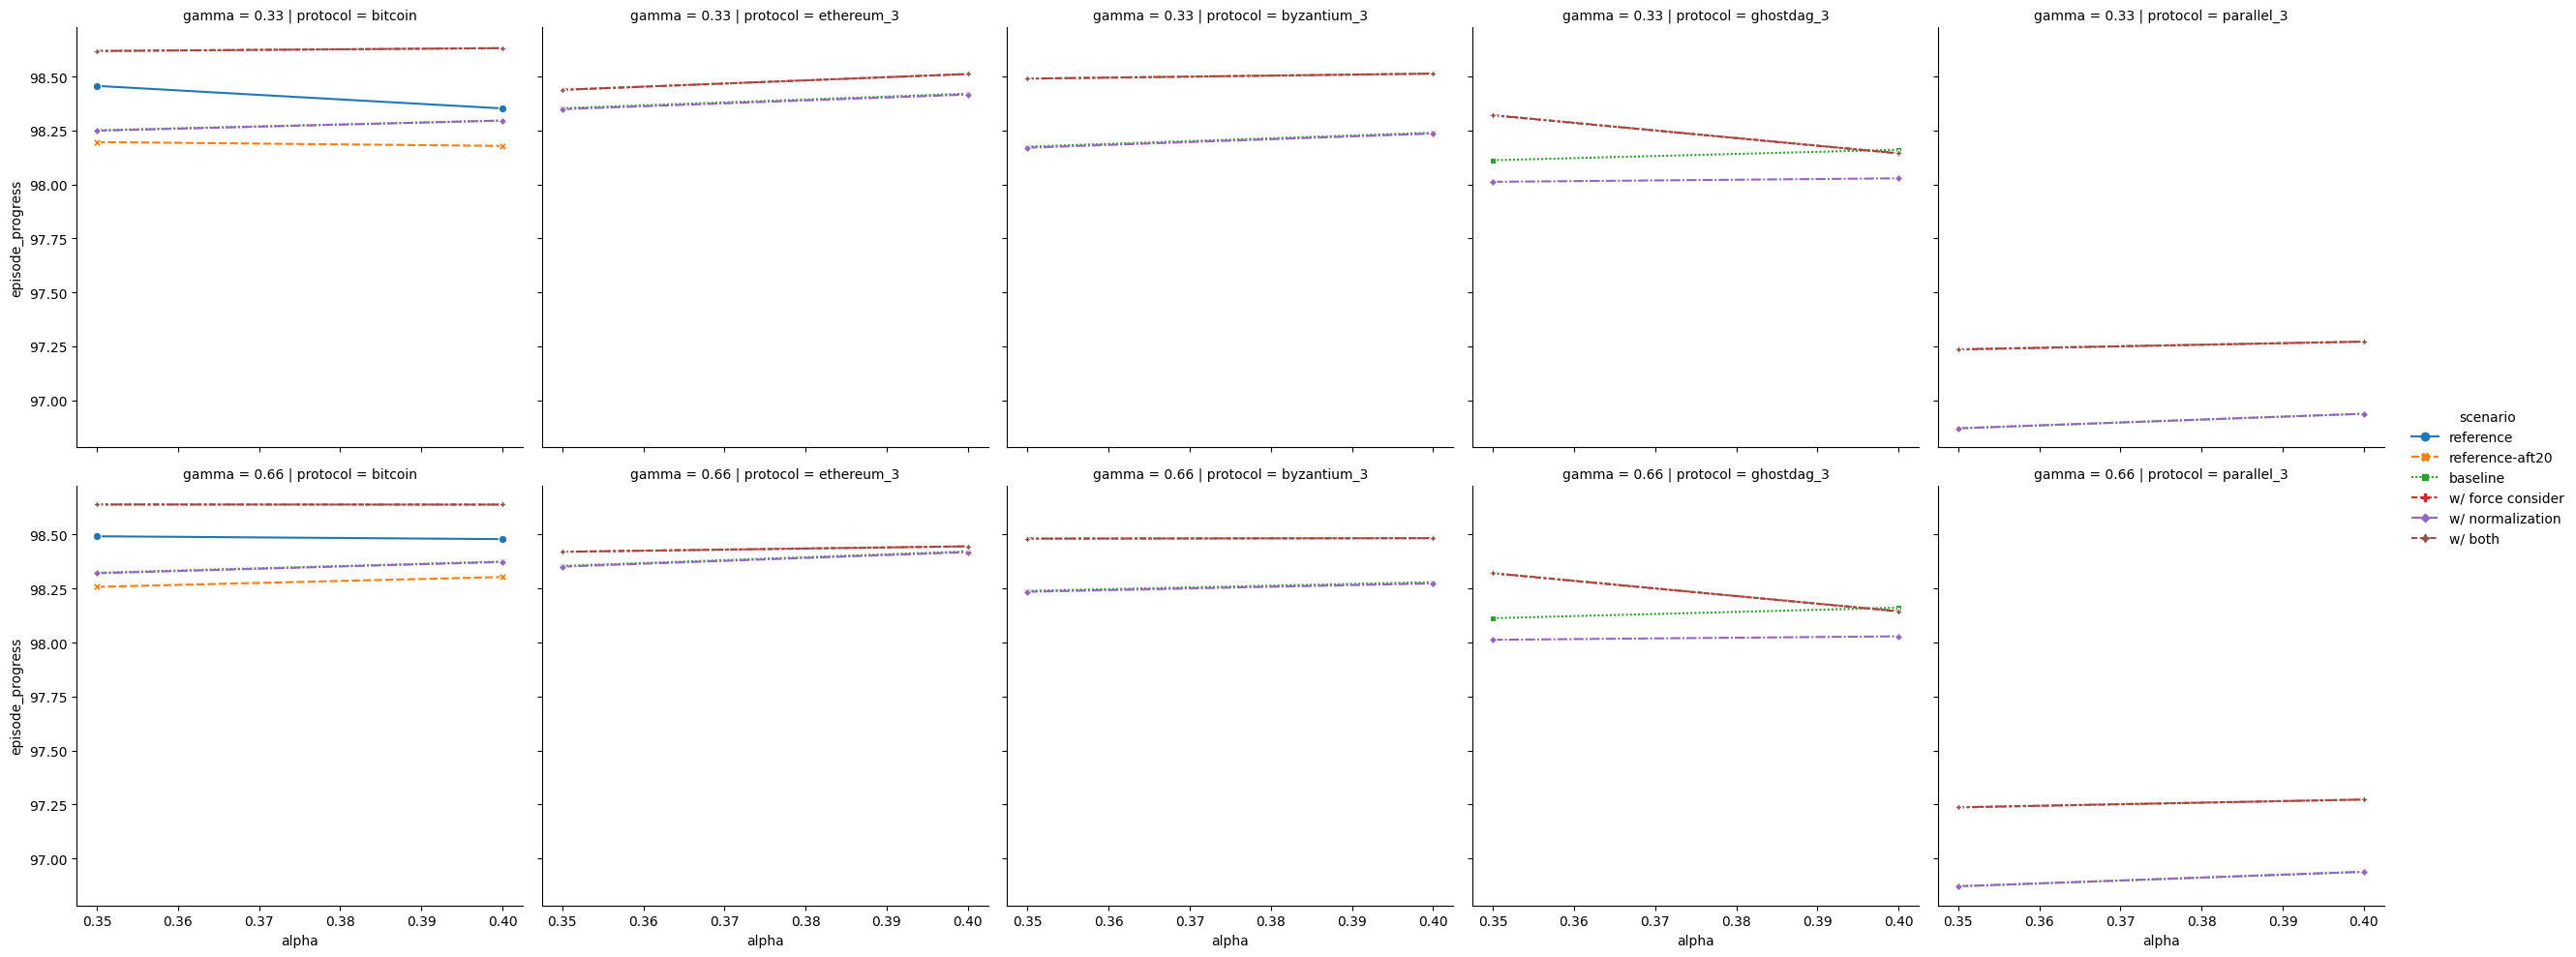

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

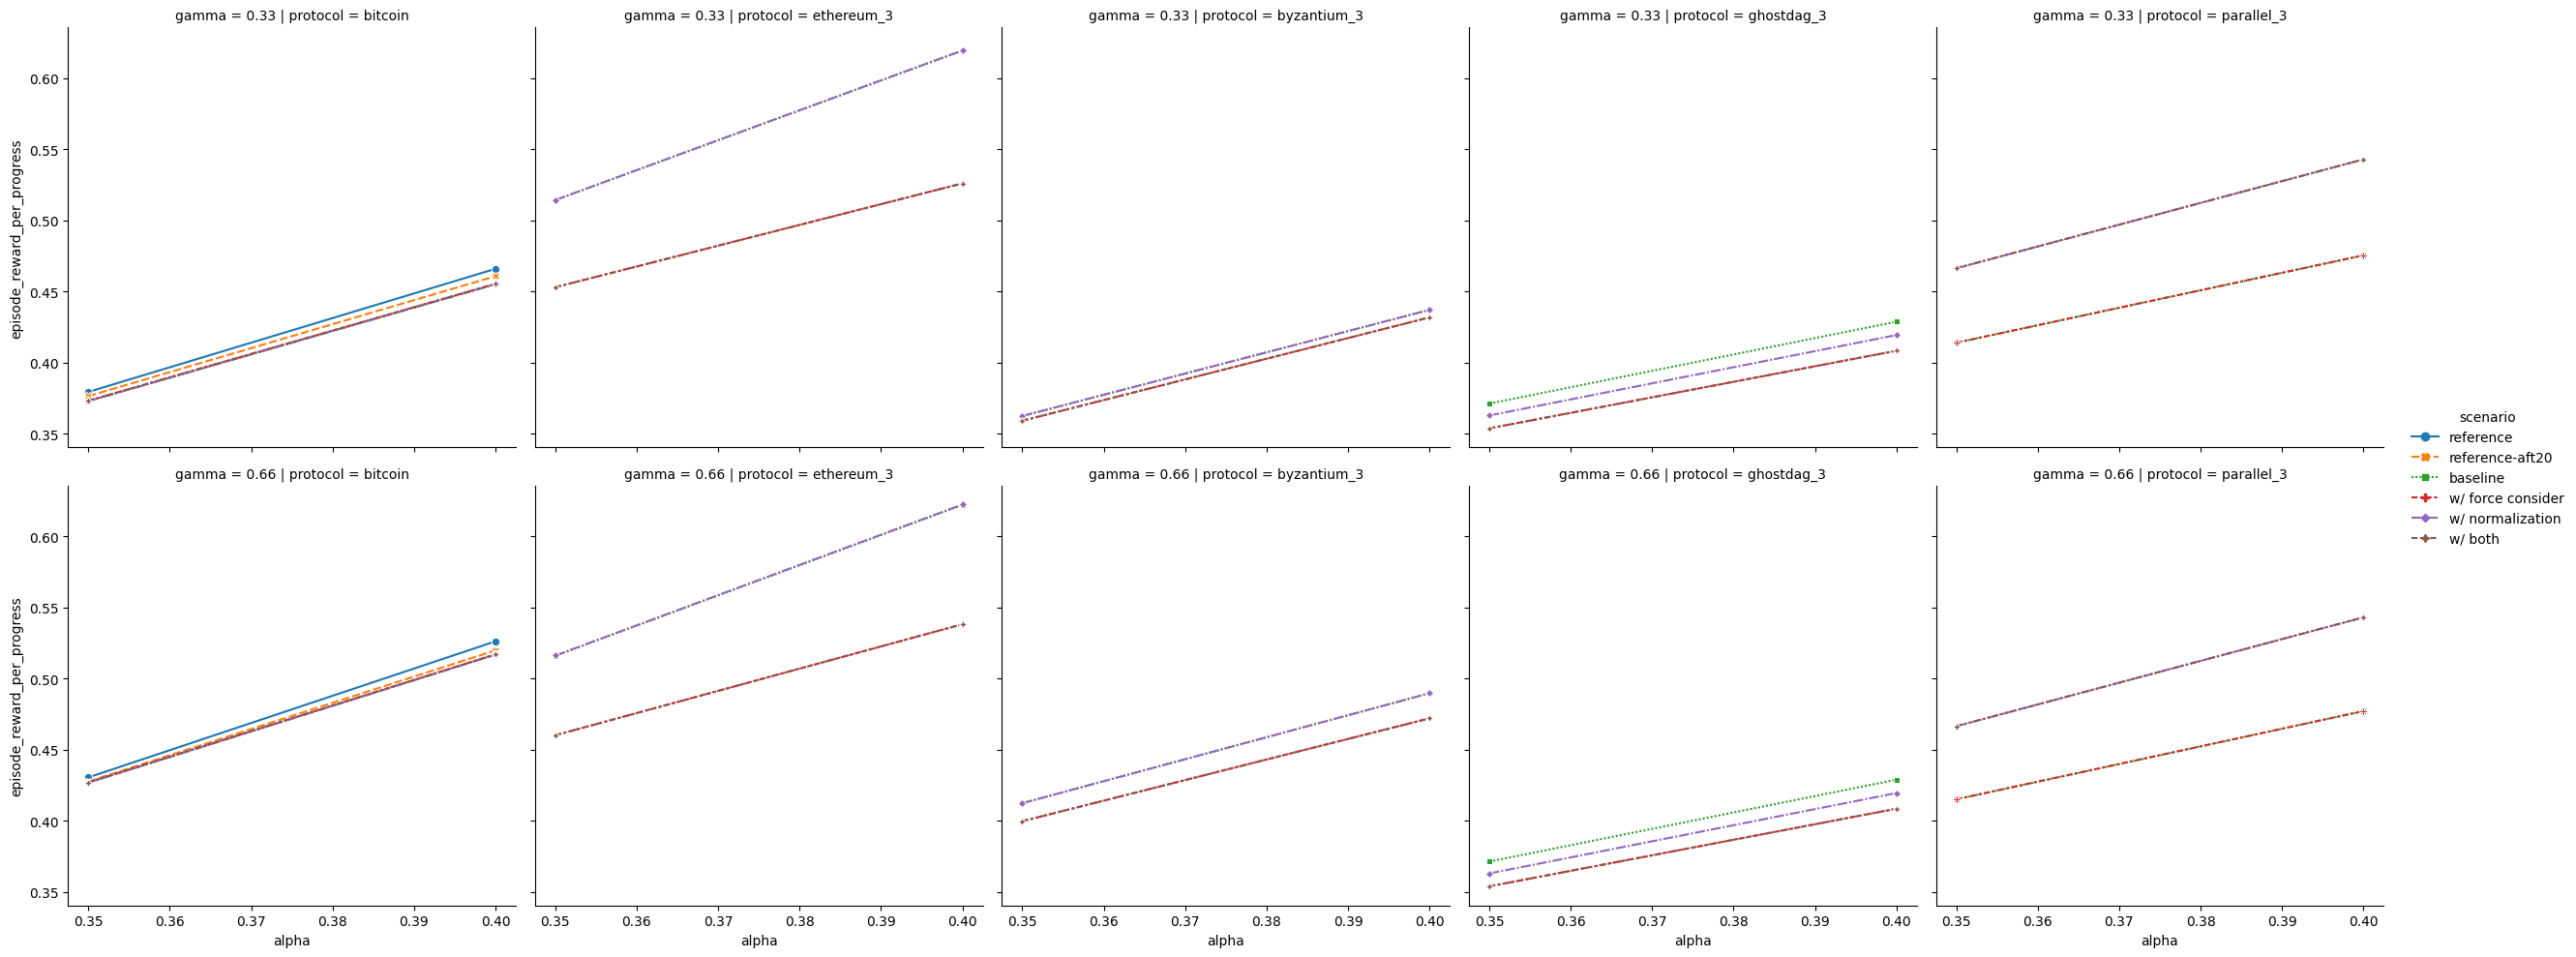

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

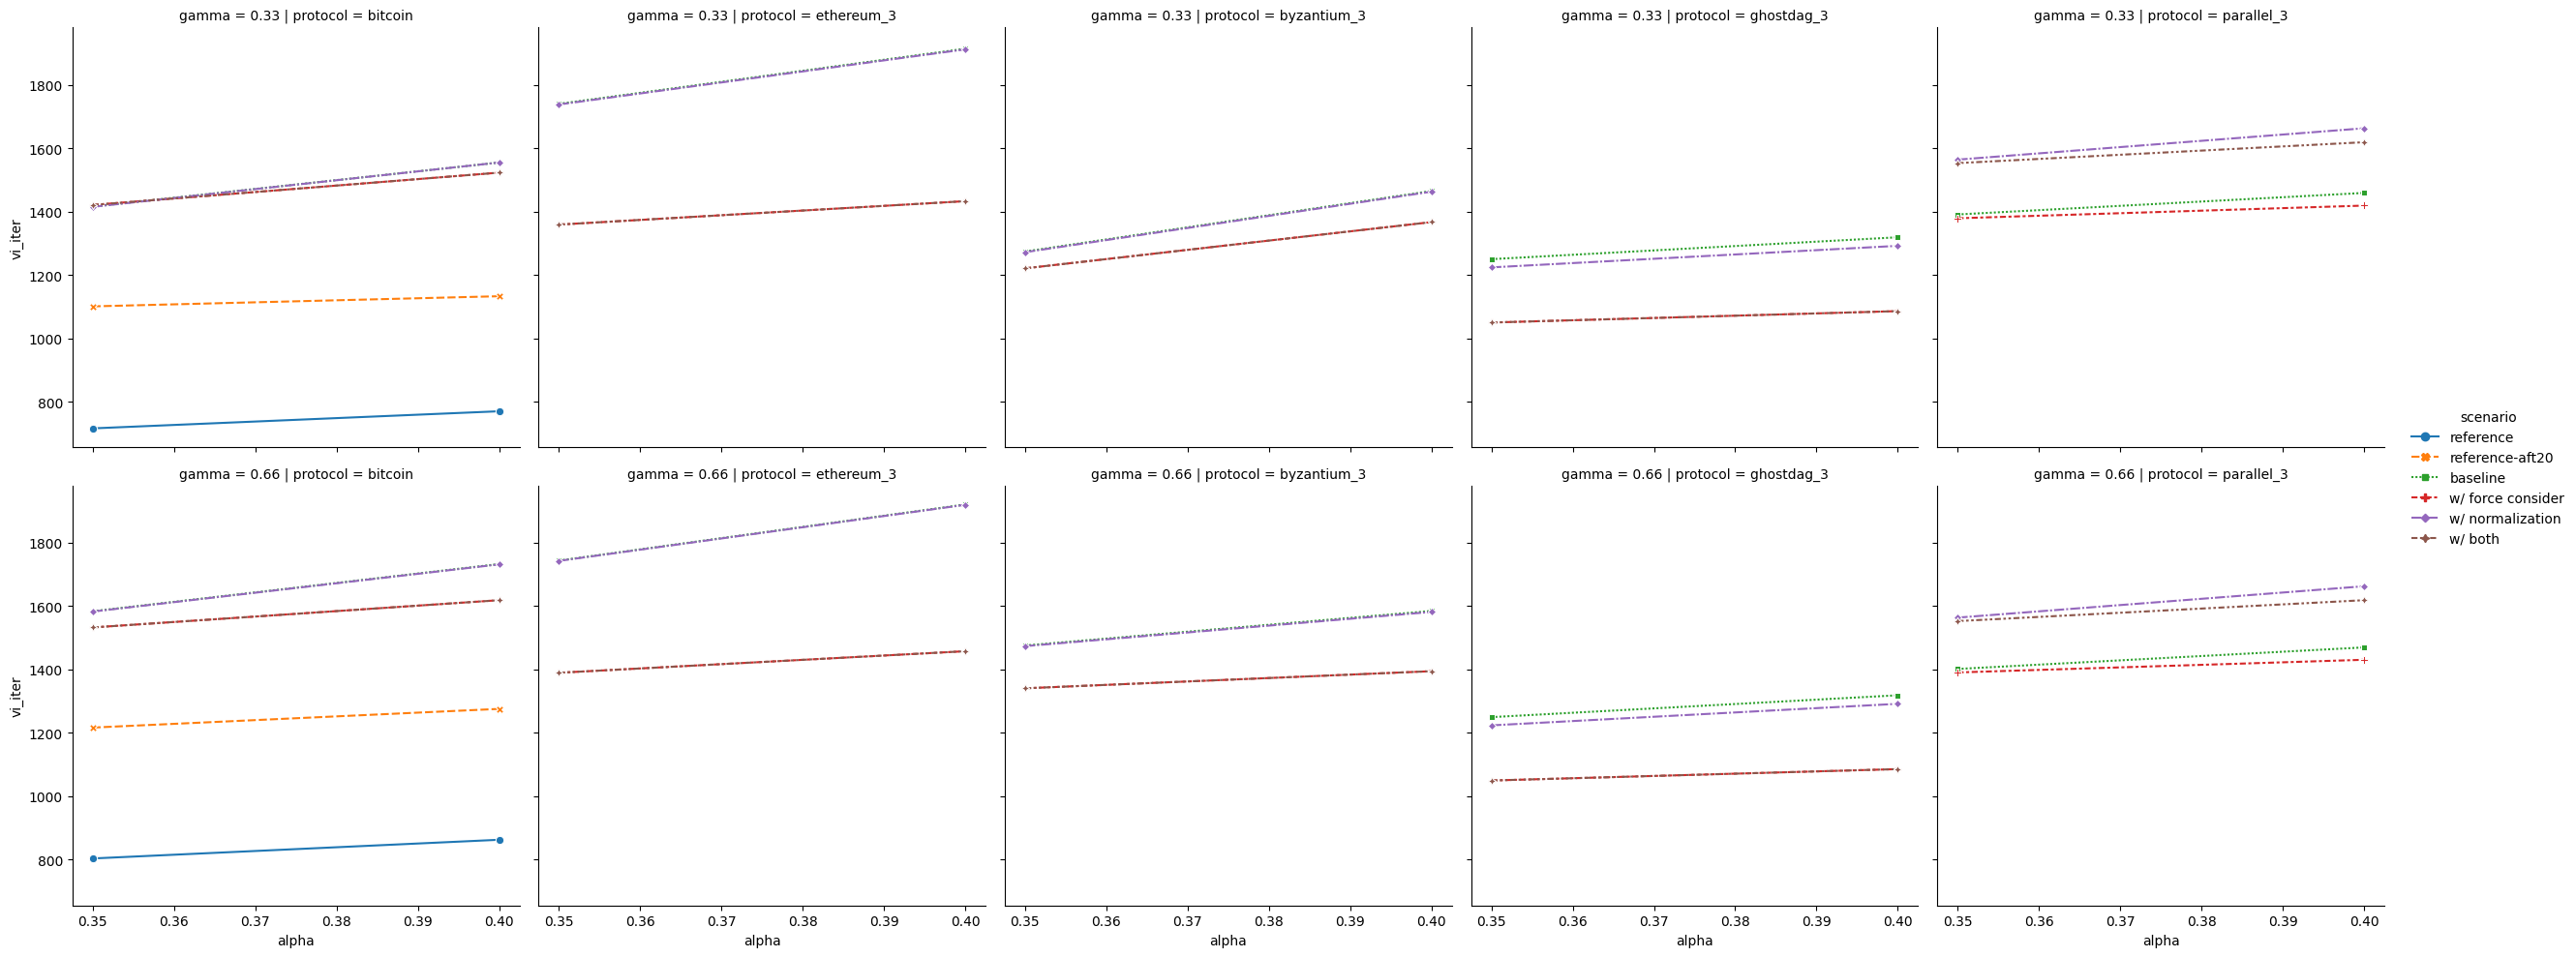

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)